In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from itertools import cycle, islice
import h5py 

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(10)

/Users/maxim/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.mixture import GaussianMixture

## Подготовим данные

In [3]:
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
data = pd.read_csv('../../datasets/SUSY.csv', header=None, names=column_names)

In [4]:
data.head()

,label,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [5]:
data.shape

(5000000, 19)

Делим выборку на признаки и таргеты. Нормируем признаки.

$X_{new} = \frac{X - \mu}{\sigma}$

In [6]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

Перемешиваем данные(неясно зачем, если train_test_split сам это умеет)

In [7]:
idx = np.random.permutation(len(labels))
X_data, labels = X_data[idx], labels[idx]

Разбиваем на train(3% от всех данных) и test(1%)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), 
                                         stratify=labels, train_size=3e-2, test_size=1e-2, random_state=5)

In [11]:
y_train = labels[indx_train].reset_index(drop=True)
y_test = labels[indx_test].reset_index(drop=True)

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [12]:
y_train.head()

0    0.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: label, dtype: float64

In [13]:
y_test.head()

0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: label, dtype: float64

Разбиваем объекты по классам

In [14]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [15]:
X_good.shape, X_train.shape, X_data.shape

((81250, 18), (150000, 18), (5000000, 18))

Судя по размеру X_good, нельзя сказать, что второй класс - аномалия, поскольку классы сбалансированы

## Сгенерируем примеры используя GMM подход

Обучим смесь на нейтральных примерах

In [16]:
gm = GaussianMixture(n_components=15, n_init=6, covariance_type="full", verbose=0)

In [17]:
%%time
gm.fit(X_good)

CPU times: user 3min 2s, sys: 1min 22s, total: 4min 24s
Wall time: 3min 35s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=15, n_init=6, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [18]:
gm.bic(X_good)

977826.5455950544

Генерируем выборку размера исходной нейтральной следующим образом:
- Для каждой компоненты смеси распределения, сэмплируем свои примеры с востановленными матожиданием и матрицей ковариаций
- Количество примеров для компоненты пропорционально ее вкладу в смесь

In [19]:
from scipy.stats import multivariate_normal

In [20]:
n_samples = X_good.shape[0]

In [21]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], 
                                       size=int(gm.weights_[0]*n_samples)))
for d in range(1, gm.n_components):
    gen=np.vstack((
        gen, multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))
    ))
np.random.shuffle(gen)
gen = np.array(gen)

Посчитаем плотности вероятности на сгенерированных объектах для каждой компоненты смеси

In [22]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [23]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], cov=gm.covariances_[d], allow_singular=True)

In [24]:
gen.shape

(81244, 18)

Выберем для каждого объекта наибольшую вероятность по всем компонентам и инвертируем это значение для получения веса

Т.е. нам интересны те примеры, которые мало вероятно появляются в восстановленной смеси распределения(необычное поведение == аномалия)

In [25]:
maxprob = np.max(probabilities, axis=0)
gen_w = 1./(maxprob + 1e-2)

Веса ограничены сверху 100. Из этого графика мало что понятно, так как точек слигком много. Можно сказаль лишь то, что около граничных значений весов точек намного больше, чем в середине.

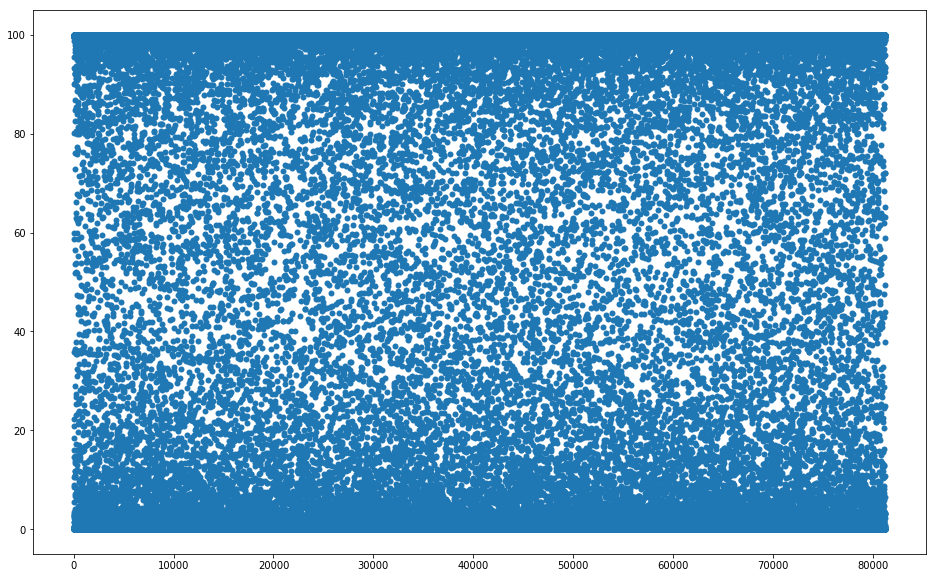

In [26]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(gen_w)), gen_w, linewidths=0.00001)
plt.show()

Нормируем полученные веса

In [27]:
weights = np.ones((n_samples,1)) #X_train.shape[0]

In [28]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [29]:
gen_w_normed.sum(), np.sum(weights)

(81249.99999999999, 81250.0)

### <font color="red">Посмотрел презентацию, но так и не понял зачем мы объединяем известные по исходным данным нейтральные объекты и сгенерированые?</font>

In [30]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [31]:
X_mix = np.vstack((gen, X_good)) 

y_mix = np.vstack((y2, y1))

weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)

In [32]:
weights_mix.shape

(162494,)

## Обучим на этом нейронку

In [33]:
# import tensorflow as tf
# s = tf.InteractiveSession()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.
/Users/maxim/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Простейшая сверточная сеть для одноклассовой классификации(по сути все равно двухклассовая)

In [34]:
def build_net():
    net = Sequential()
    net.add(L.Dense(80, input_shape=(X_good.shape[1],), activation = 'relu'))
    #net.add(L.BatchNormalization())
    #net.add(L.Dense(32, activation='relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.2))
    net.add(L.Dense(1, activation='sigmoid'))

    adam = keras.optimizers.Adam(lr=0.001)
    net.compile(optimizer=adam, loss='binary_crossentropy')
    return net

Строит зависимость ошибок от эпохи

In [35]:
# summarize history for loss
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

In [36]:
ours_roc_aucs = {}
ours_pr_aucs = {}
ours_p_at_10 = {}
ours_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

Реализуем функции для вычисления precision at recall и precision at 10

In [37]:
def p_at_10(y_test, y_pred, n=10):
    ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean

In [38]:
def p_at_r(y_test, y_pred, x):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return max(precision[recall > x])

In [39]:
def _eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        if descr in ours_p_at_r[recall]:
            # append the new number to the existing array at this slot
            ours_p_at_r[recall][descr].append(p_at_r(y_test, y_pred, float(recall)))
        else:
            # create a new array in this slot
            ours_p_at_r[recall][descr] = [p_at_r(y_test, y_pred, float(recall))]
            
def _eval_p_at_rs_flatten(y_test, y_pred, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        ours_p_at_r[recall][descr] = p_at_r(y_test, y_pred, float(recall))

Посмотрим на значения весов объектов в объединенной выборке

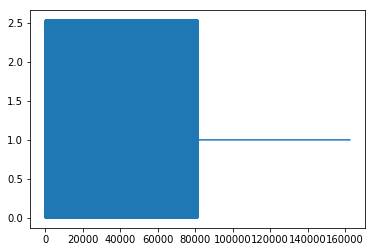

In [40]:
plt.plot(weights_mix)
plt.show()

Обучим нейронку с нашими весами, перемешав данные дважды(видимо я что-то не понимаю, но зачем так делать)?

Train on 146244 samples, validate on 16250 samples
Epoch 1/130
146244/146244 [==============================] - 1s 9us/step - loss: 0.7992 - val_loss: 0.6675
Epoch 2/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.7146 - val_loss: 0.6539
Epoch 3/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.6844 - val_loss: 0.6489
Epoch 4/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.6668 - val_loss: 0.6436
Epoch 5/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.6573 - val_loss: 0.6391
Epoch 6/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.6495 - val_loss: 0.6371
Epoch 7/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.6423 - val_loss: 0.6331
Epoch 8/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.6380 - val_loss: 0.6301
Epoch 9/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.6302 - val

146244/146244 [==============================] - 1s 6us/step - loss: 0.2630 - val_loss: 0.2184
Epoch 77/130
146244/146244 [==============================] - 1s 6us/step - loss: 0.2638 - val_loss: 0.2168
Epoch 78/130
146244/146244 [==============================] - 1s 5us/step - loss: 0.2625 - val_loss: 0.2139
Epoch 79/130
146244/146244 [==============================] - 1s 6us/step - loss: 0.2628 - val_loss: 0.2128
Epoch 80/130
146244/146244 [==============================] - 1s 6us/step - loss: 0.2598 - val_loss: 0.2117
Epoch 81/130
146244/146244 [==============================] - 1s 6us/step - loss: 0.2589 - val_loss: 0.2096
Epoch 82/130
146244/146244 [==============================] - 1s 6us/step - loss: 0.2560 - val_loss: 0.2077
Epoch 83/130
146244/146244 [==============================] - 1s 6us/step - loss: 0.2529 - val_loss: 0.2047
Epoch 84/130
146244/146244 [==============================] - 1s 6us/step - loss: 0.2530 - val_loss: 0.2023
Epoch 85/130
146244/146244 [=============

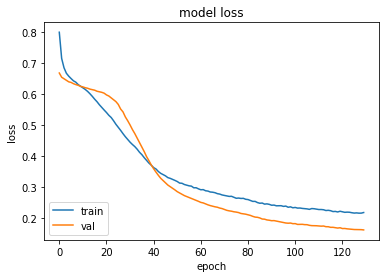

CPU times: user 4min 17s, sys: 18.2 s, total: 4min 35s
Wall time: 1min 46s


In [41]:
%%time
idx = np.random.permutation(len(y_mix))

net = build_net()
history = net.fit(X_mix[idx], y_mix[idx], 
                  batch_size=10000, epochs=130, validation_split=0.1, verbose=1, shuffle=True, 
                  sample_weight=weights_mix[idx])
history_plot(history)

Посмотрим на результаты

50000/50000 [==============================] - 1s 23us/step

f1_score  0.07785363516588813
confusion_matrix 
[[25928  1191]
 [21906   975]]


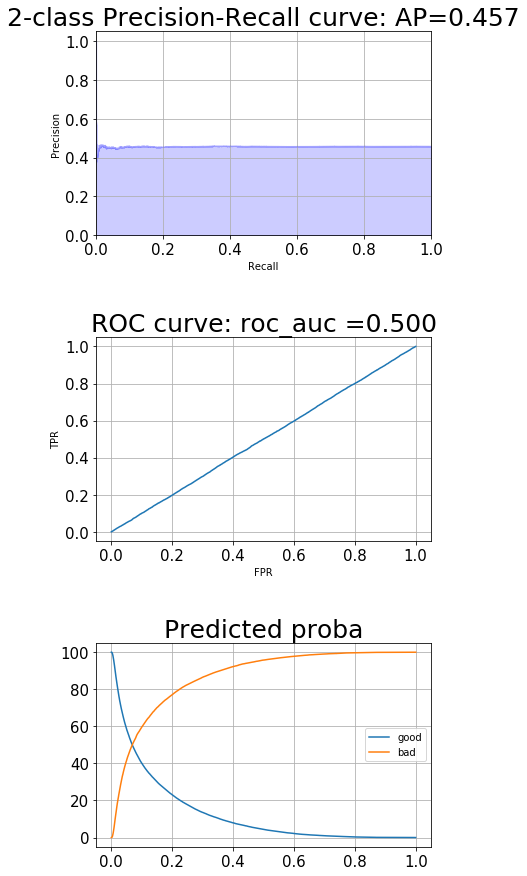

In [42]:
y_pred = net.predict_proba(X_test, verbose=1)
ours_pr_aucs['ours with alpha=0.'] = [average_precision_score(y_test, y_pred)]
ours_roc_aucs['ours with alpha=0.'] = [roc_auc_score(y_test, y_pred)]
ours_p_at_10['ours with alpha=0.'] = [p_at_10(y_test, y_pred)]
_eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr='ours with alpha=0.')

print ('')
perfomance(y_test, y_pred)

Похоже алгоритм почти всегда отвечает классом 1 (о чем должен говорить последний график из построения так и не понял?)

## Получим значения при разных долях включения истинных аномалий

Инициализируем веса объектов обратно пропорционально доли класса в выборке

In [43]:
len(y_train)-np.sum(y_train)

81250.0

In [44]:
np.sum(y_train)

68750.0

In [45]:
len(y_train)

150000

In [46]:
len(y_train)/np.where(y_train == 0.0, len(y_train)-np.sum(y_train), np.sum(y_train))

array([1.84615385, 1.84615385, 2.18181818, ..., 2.18181818, 1.84615385,
       1.84615385])

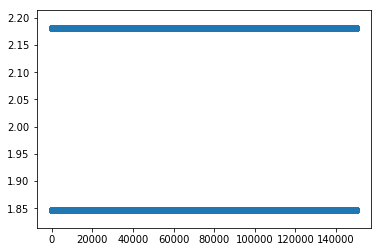

In [47]:
weights_train = np.array(len(y_train)/np.where(y_train == 0.0, len(y_train)-np.sum(y_train), np.sum(y_train)))
plt.scatter(np.arange(len(y_train)), weights_train.ravel())
plt.show()

Обучим нейронки при разных долях участия аномалий в выборке(10 долей, $\alpha$=1)

In [48]:
import math
n_splits=10
step = math.ceil((X_bad.shape[0]/(n_splits)))

In [49]:
from tqdm import tqdm

  0%|          | 0/10 [00:00<?, ?it/s]

50000/50000 [==============================] - 1s 21us/step


 10%|█         | 1/10 [02:06<18:55, 126.17s/it]

50000/50000 [==============================] - 1s 27us/step 


 20%|██        | 2/10 [04:33<18:15, 136.97s/it]

50000/50000 [==============================] - 1s 22us/step


 30%|███       | 3/10 [07:02<16:25, 140.78s/it]

50000/50000 [==============================] - 1s 24us/step


 40%|████      | 4/10 [09:40<14:30, 145.10s/it]

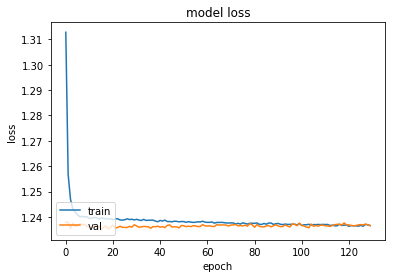

50000/50000 [==============================] - 1s 25us/step


 50%|█████     | 5/10 [12:26<12:26, 149.29s/it]

50000/50000 [==============================] - 1s 25us/step


 60%|██████    | 6/10 [15:23<10:15, 153.84s/it]

50000/50000 [==============================] - 1s 24us/step


 70%|███████   | 7/10 [18:30<07:56, 158.71s/it]

50000/50000 [==============================] - 1s 26us/step


 80%|████████  | 8/10 [21:44<05:26, 163.11s/it]

50000/50000 [==============================] - 1s 25us/step


 90%|█████████ | 9/10 [25:10<02:47, 167.81s/it]

50000/50000 [==============================] - 2s 34us/step


100%|██████████| 10/10 [28:51<00:00, 173.19s/it]

CPU times: user 57min 23s, sys: 6min 29s, total: 1h 3min 52s
Wall time: 28min 51s


In [50]:
%%time
alpha=1
for i in tqdm(range(1,n_splits+1)):
    if step*i>X_bad.shape[0]:
        end_ind=X_bad.shape[0]
    else:   
        end_ind=int(step*i)

    cur_X = np.concatenate((X_good, X_bad[:end_ind]))
    cur_y = np.concatenate(
        (np.zeros((X_good.shape[0], 1)), np.ones((end_ind, 1)))
    ).ravel()
    cur_w = np.concatenate(
        (np.min(weights_train)*np.ones((X_good.shape[0], 1)), np.max(weights_train)*np.ones((end_ind, 1)))
    ).ravel()
    
    idx = np.random.permutation(len(cur_y))
    cur_X, cur_y, cur_w = cur_X[idx], cur_y[idx], cur_w[idx]

    net = build_net()
    history = net.fit(cur_X, cur_y, 
                      batch_size=256, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                      sample_weight=cur_w)
    if i==5:
        history_plot(history)

    y_pred=net.predict_proba(X_test)
    if alpha in ours_pr_aucs:
        # append the new number to the existing array at this slot
        ours_pr_aucs[alpha].append(average_precision_score(y_test, y_pred))
        ours_roc_aucs[alpha].append(roc_auc_score(y_test, y_pred))
        ours_p_at_10[alpha].append(p_at_10(y_test, y_pred))
    else:
        # create a new array in this slot
        ours_pr_aucs[alpha] = [average_precision_score(y_test, y_pred)]
        ours_roc_aucs[alpha] = [roc_auc_score(y_test, y_pred)]
        ours_p_at_10[alpha] = [p_at_10(y_test, y_pred)]
    _eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr=alpha)

In [51]:
ours_pr_aucs, ours_roc_aucs, ours_p_at_10, ours_p_at_r

({'ours with alpha=0.': [0.45691096904931294],
  1: [0.4564743657057639,
   0.4555757181713848,
   0.455156479837069,
   0.45451950913090394,
   0.45757313820465007,
   0.45566009204642316,
   0.45607830394904014,
   0.45477386831204586,
   0.45736006753506486,
   0.45304535034309085]},
 {'ours with alpha=0.': [0.4997106306963813],
  1: [0.4990254779827915,
   0.4976116615614212,
   0.49609984427660303,
   0.4965708077998744,
   0.5005403467905365,
   0.49959795077479824,
   0.4970713373329766,
   0.49503126089834654,
   0.4989951609776167,
   0.49324704180879236]},
 {'ours with alpha=0.': [0.5],
  1: [0.3, 0.3, 0.5, 0.4, 0.3, 0.3, 0.1, 0.3, 0.6, 0.4]},
 {'0.8': {'ours with alpha=0.': [0.4583272054961447],
   1: [0.45785120330854856,
    0.4580232609954993,
    0.45770401887439255,
    0.45807524139187467,
    0.4587965501769779,
    0.4585236723124136,
    0.4576454777044511,
    0.4579033358840196,
    0.4584054555692269,
    0.4576959414638069]},
  '0.9': {'ours with alpha=0.': [0.4

Обучим нейронки при разных долях участия аномалий в выборке(10 $\alpha$ * 10 долей)

In [52]:
points_cnt = 10
alphas = np.exp([np.log(0.05) * (points_cnt - i) * 1/points_cnt for i in range(points_cnt)]) # log scale
# alphas = [0.05, 0.1, 0.3, 0.5, 0.9]

In [53]:
print(alphas)

[0.05       0.06746414 0.09102821 0.1228228  0.1657227  0.2236068
 0.30170882 0.40709053 0.54928027 0.74113445]


Функция обновления весов

Вклад нейтральных и отрицательных объектов одинаковый

В отрицательных вклад истинных аномалий=$\alpha$, а сгенерированных=$(1 - \alpha)$

In [54]:
def upd_weights(alpha, y_mix, num_true_bad, w_g=gen_w_normed):
    # sum of weights for good and bad data: beta * bad + (1 - beta) * good
    # proportion of weights between real and fake data id alpha: alpha * true + (1 - alpha) * fake
    num_good = len(y_mix)-np.sum(y_mix)
    num_fake_bad = np.sum(y_mix)
    sum_w = num_good+num_fake_bad+num_true_bad
    
    beta = 0.5
    w_good = (1-beta)/num_good * np.ones((int(num_good),1))
    
    w_fake_bad = (1-alpha)*beta/num_fake_bad * w_g
    w_fake_bad = w_fake_bad.reshape(-1,1)
    
    if num_true_bad!=0:
        w_true_bad = alpha*beta/num_true_bad *np.ones((int(num_true_bad),1))
    else:
        w_true_bad=np.empty((0,1))
                           
    return sum_w*np.vstack((w_fake_bad, w_good, w_true_bad))

  0%|          | 0/11 [00:00<?, ?it/s]

0.05000000000000001


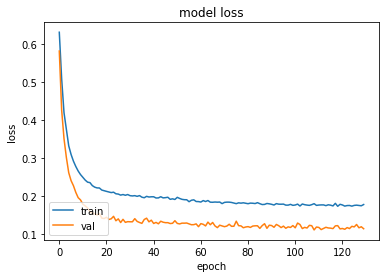

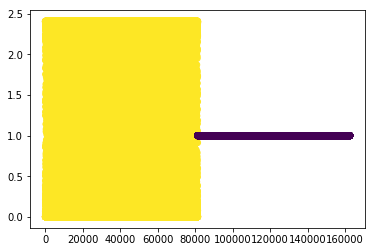

50000/50000 [==============================] - 2s 36us/step



  9%|▉         | 1/11 [04:53<48:52, 293.26s/it]

50000/50000 [==============================] - 1s 29us/step



 18%|█▊        | 2/11 [09:29<42:43, 284.89s/it]

50000/50000 [==============================] - 2s 31us/step



 27%|██▋       | 3/11 [14:04<37:32, 281.51s/it]

0.05000000000000001


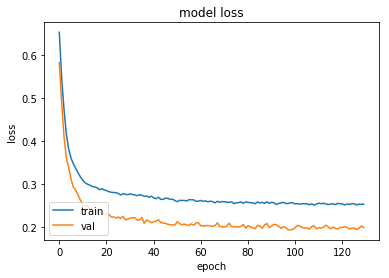

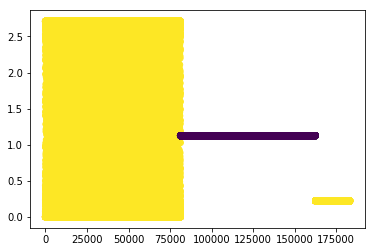

50000/50000 [==============================] - 1s 30us/step



 36%|███▋      | 4/11 [18:47<32:53, 281.93s/it]

50000/50000 [==============================] - 1s 30us/step



 45%|████▌     | 5/11 [23:28<28:09, 281.64s/it]

50000/50000 [==============================] - 2s 30us/step



 55%|█████▍    | 6/11 [28:23<23:39, 283.98s/it]

0.05000000000000001


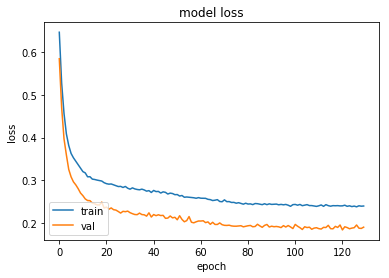

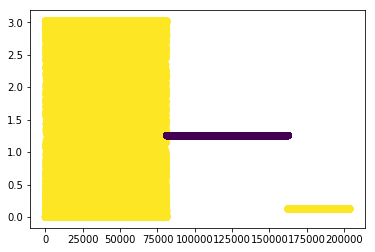

50000/50000 [==============================] - 2s 41us/step



 64%|██████▎   | 7/11 [33:36<19:12, 288.10s/it]

50000/50000 [==============================] - 2s 40us/step



 73%|███████▎  | 8/11 [40:02<15:01, 300.34s/it]

50000/50000 [==============================] - 2s 32us/step



 82%|████████▏ | 9/11 [45:31<10:07, 303.54s/it]

0.05000000000000001


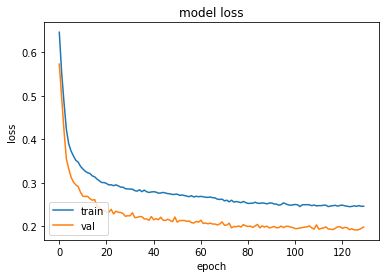

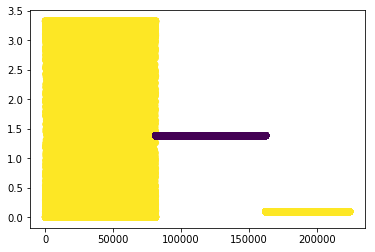

50000/50000 [==============================] - 2s 35us/step



 91%|█████████ | 10/11 [51:30<05:09, 309.00s/it]

50000/50000 [==============================] - 2s 34us/step



  0%|          | 0/11 [00:00<?, ?it/s]

0.06746414238367818


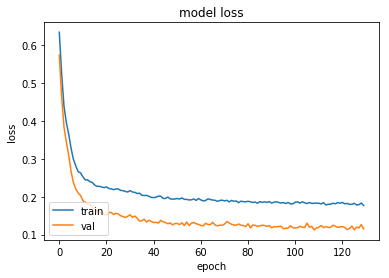

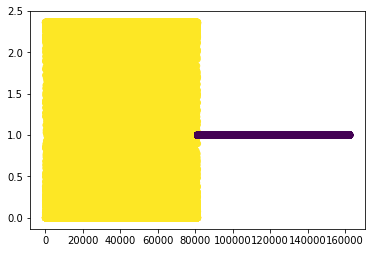

50000/50000 [==============================] - 2s 36us/step



  9%|▉         | 1/11 [04:20<43:28, 260.83s/it]

50000/50000 [==============================] - 2s 37us/step



 18%|█▊        | 2/11 [08:54<40:03, 267.06s/it]

50000/50000 [==============================] - 2s 36us/step



 27%|██▋       | 3/11 [13:35<36:15, 271.95s/it]

0.06746414238367818


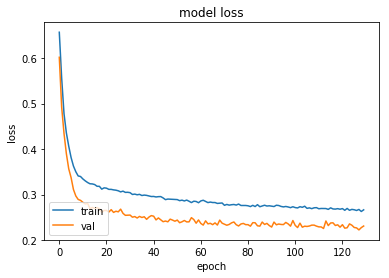

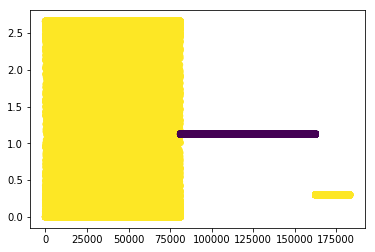

50000/50000 [==============================] - 2s 38us/step



 36%|███▋      | 4/11 [18:23<32:10, 275.84s/it]

50000/50000 [==============================] - 2s 38us/step



 45%|████▌     | 5/11 [23:31<28:13, 282.26s/it]

50000/50000 [==============================] - 2s 39us/step



 55%|█████▍    | 6/11 [28:32<23:47, 285.42s/it]

0.06746414238367818


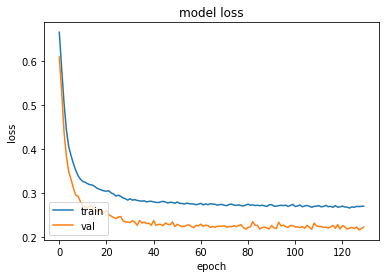

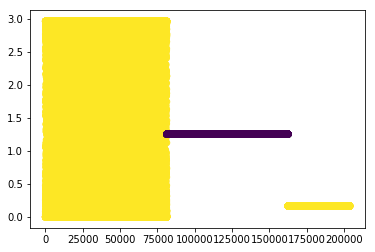

50000/50000 [==============================] - 2s 41us/step



 64%|██████▎   | 7/11 [33:53<19:21, 290.47s/it]

50000/50000 [==============================] - 2s 43us/step



 73%|███████▎  | 8/11 [39:17<14:43, 294.63s/it]

50000/50000 [==============================] - 2s 43us/step



 82%|████████▏ | 9/11 [44:57<09:59, 299.69s/it]

0.06746414238367818


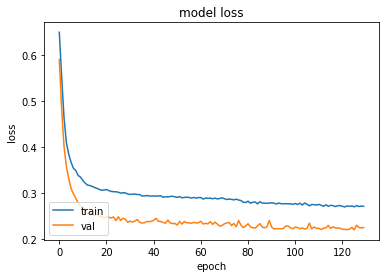

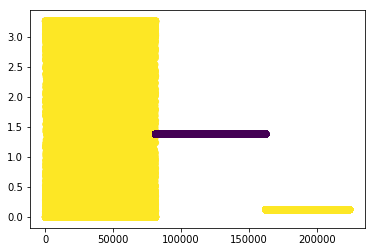

50000/50000 [==============================] - 2s 42us/step



 91%|█████████ | 10/11 [51:04<05:06, 306.41s/it]

50000/50000 [==============================] - 2s 44us/step



  0%|          | 0/11 [00:00<?, ?it/s]

0.09102821015130401


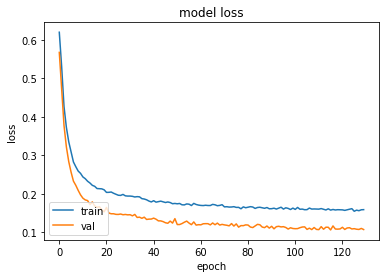

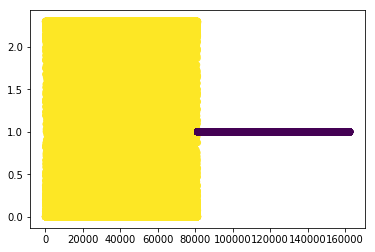

50000/50000 [==============================] - 2s 46us/step



  9%|▉         | 1/11 [04:28<44:48, 268.86s/it]

50000/50000 [==============================] - 2s 49us/step



 18%|█▊        | 2/11 [09:04<40:48, 272.02s/it]

50000/50000 [==============================] - 2s 48us/step



 27%|██▋       | 3/11 [13:51<36:58, 277.28s/it]

0.09102821015130401


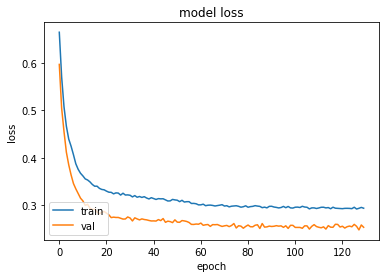

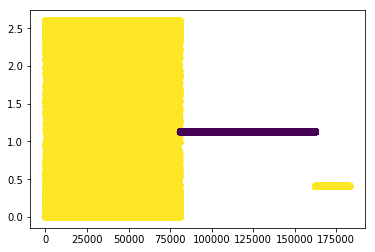

50000/50000 [==============================] - 2s 49us/step



 36%|███▋      | 4/11 [19:02<33:18, 285.55s/it]

50000/50000 [==============================] - 2s 47us/step



 45%|████▌     | 5/11 [24:14<29:05, 290.88s/it]

50000/50000 [==============================] - 2s 48us/step



 55%|█████▍    | 6/11 [29:41<24:44, 296.89s/it]

0.09102821015130401


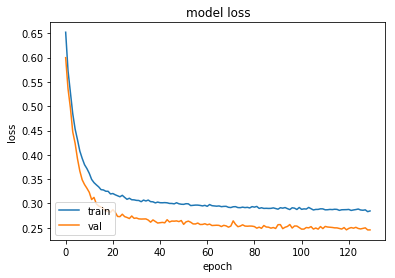

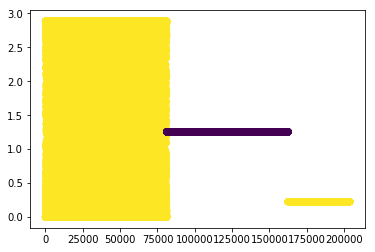

50000/50000 [==============================] - 2s 50us/step



 64%|██████▎   | 7/11 [35:25<20:14, 303.71s/it]

50000/50000 [==============================] - 2s 49us/step



 73%|███████▎  | 8/11 [41:19<15:29, 309.93s/it]

50000/50000 [==============================] - 3s 52us/step



 82%|████████▏ | 9/11 [47:23<10:31, 315.95s/it]

0.09102821015130401


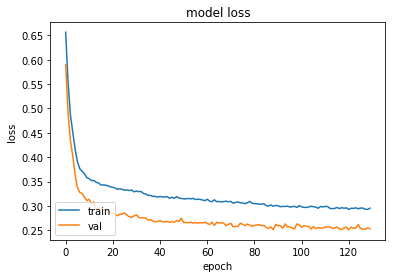

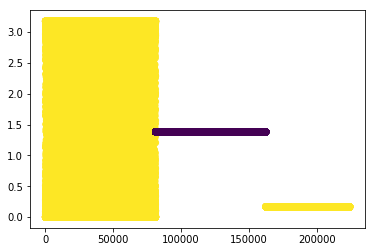

50000/50000 [==============================] - 3s 51us/step



 91%|█████████ | 10/11 [53:49<05:22, 322.94s/it]

50000/50000 [==============================] - 3s 50us/step



100%|██████████| 3/3 [2:54:54<00:00, 3498.25s/it]

CPU times: user 5h 32min 54s, sys: 36min 22s, total: 6h 9min 16s
Wall time: 2h 54min 54s


In [55]:
%%time
for alpha in tqdm(alphas[:3]):
    for i in tqdm(range(0, n_splits + 1)):
        if step*i>len(X_bad):
            end_ind=len(X_bad)
        else:   
            end_ind=step*i    
        end_ind = int(end_ind)
        cur_X = np.concatenate((X_mix, X_bad[:end_ind]))
        cur_y = np.concatenate((y_mix, np.ones((end_ind,1)))).ravel()
        cur_w = upd_weights(alpha, y_mix, w_g=gen_w_normed, num_true_bad=end_ind).ravel()
        
        idx = np.random.permutation(len(cur_y))    
    
        net = build_net()
        history = net.fit(cur_X[idx], cur_y[idx], 
                          batch_size=256, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                          sample_weight=cur_w[idx])
        if i%3==0:
            print (alpha)
            history_plot(history)
            
            plt.scatter(np.arange(len(cur_w)), cur_w, c=cur_y)#np.concatenate((y_mix, 2*np.ones((end_ind,1)))).ravel())
            plt.show()

        y_pred=net.predict_proba(X_test)
        if alpha in ours_pr_aucs:
            # append the new number to the existing array at this slot
            ours_pr_aucs[alpha].append(average_precision_score(y_test, y_pred))
            ours_roc_aucs[alpha].append(roc_auc_score(y_test, y_pred))
            ours_p_at_10[alpha].append(p_at_10(y_test, y_pred))
        else:
            # create a new array in this slot
            ours_pr_aucs[alpha] = [average_precision_score(y_test, y_pred)]
            ours_roc_aucs[alpha] = [roc_auc_score(y_test, y_pred)]
            ours_p_at_10[alpha] = [p_at_10(y_test, y_pred)]
        _eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr=alpha)

  0%|          | 0/11 [00:00<?, ?it/s]

0.12282280261157903


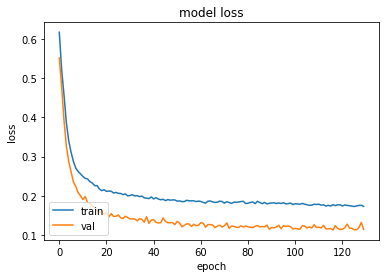

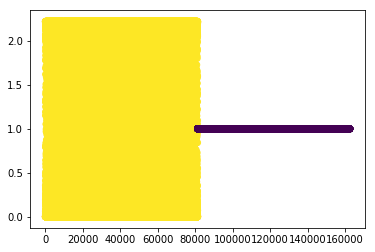

50000/50000 [==============================] - 5s 92us/step



  9%|▉         | 1/11 [04:53<48:53, 293.32s/it]

50000/50000 [==============================] - 3s 56us/step



 18%|█▊        | 2/11 [09:38<43:24, 289.34s/it]

50000/50000 [==============================] - 3s 61us/step



 27%|██▋       | 3/11 [14:32<38:46, 290.78s/it]

0.12282280261157903


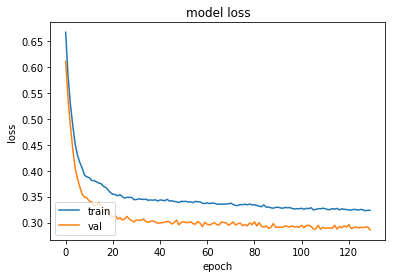

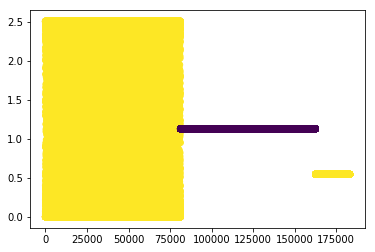

50000/50000 [==============================] - 3s 62us/step



 36%|███▋      | 4/11 [19:50<34:43, 297.60s/it]

50000/50000 [==============================] - 4s 77us/step



 45%|████▌     | 5/11 [25:38<30:46, 307.67s/it]

50000/50000 [==============================] - 4s 73us/step



 55%|█████▍    | 6/11 [31:40<26:23, 316.68s/it]

0.12282280261157903


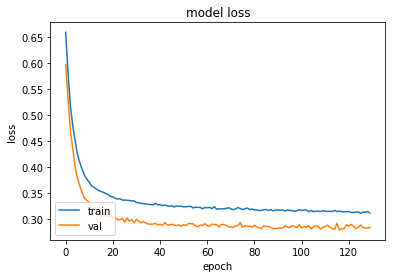

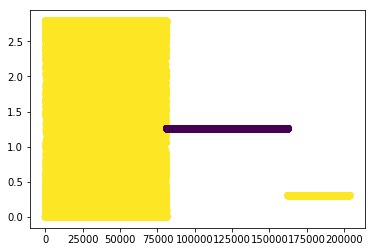

50000/50000 [==============================] - 3s 61us/step



 64%|██████▎   | 7/11 [37:29<21:25, 321.34s/it]

50000/50000 [==============================] - 3s 63us/step



 73%|███████▎  | 8/11 [43:29<16:18, 326.16s/it]

50000/50000 [==============================] - 4s 73us/step



 82%|████████▏ | 9/11 [49:43<11:02, 331.46s/it]

0.12282280261157903


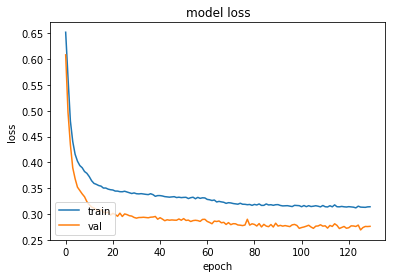

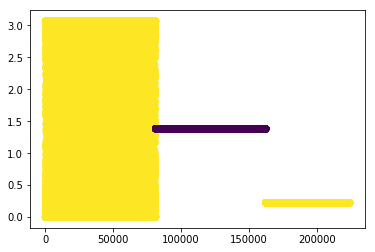

50000/50000 [==============================] - 3s 68us/step



 91%|█████████ | 10/11 [56:25<05:38, 338.58s/it]

50000/50000 [==============================] - 4s 86us/step



  0%|          | 0/11 [00:00<?, ?it/s]

0.16572270086699933


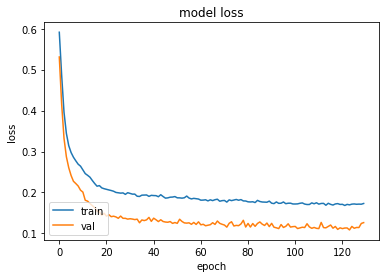

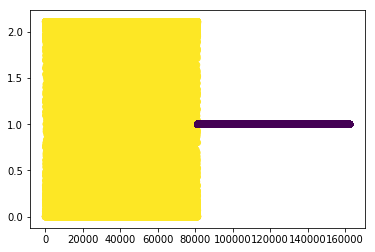

50000/50000 [==============================] - 4s 72us/step



  9%|▉         | 1/11 [04:51<48:37, 291.79s/it]

50000/50000 [==============================] - 5s 100us/step



 18%|█▊        | 2/11 [10:08<45:39, 304.33s/it]

50000/50000 [==============================] - 3s 65us/step



 27%|██▋       | 3/11 [15:22<40:58, 307.36s/it]

0.16572270086699933


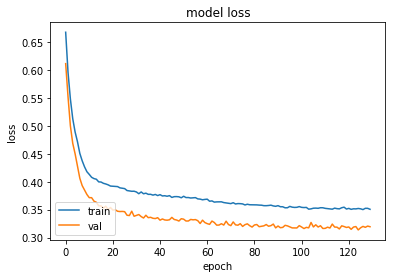

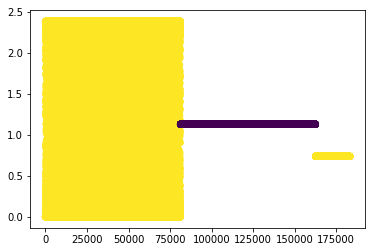

50000/50000 [==============================] - 3s 67us/step



 36%|███▋      | 4/11 [20:48<36:25, 312.20s/it]

50000/50000 [==============================] - 3s 70us/step



 45%|████▌     | 5/11 [26:22<31:39, 316.51s/it]

50000/50000 [==============================] - 4s 74us/step



 55%|█████▍    | 6/11 [32:08<26:46, 321.35s/it]

0.16572270086699933


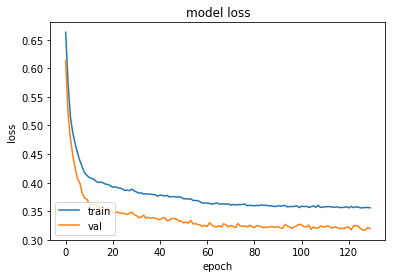

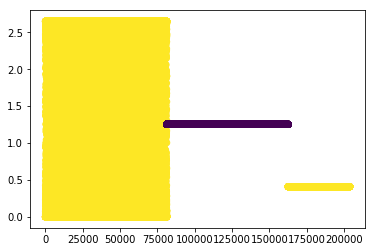

50000/50000 [==============================] - 3s 68us/step



 64%|██████▎   | 7/11 [38:15<21:51, 327.94s/it]

50000/50000 [==============================] - 4s 71us/step



 73%|███████▎  | 8/11 [44:32<16:42, 334.09s/it]

50000/50000 [==============================] - 4s 72us/step



 82%|████████▏ | 9/11 [50:56<11:19, 339.60s/it]

0.16572270086699933


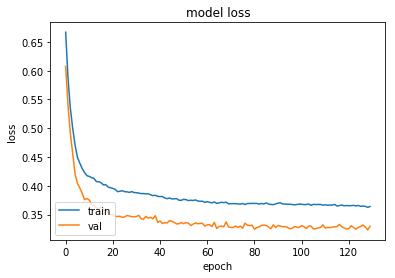

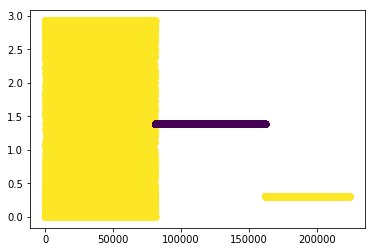

50000/50000 [==============================] - 5s 105us/step



 91%|█████████ | 10/11 [57:44<05:46, 346.43s/it]

50000/50000 [==============================] - 4s 73us/step



  0%|          | 0/11 [00:00<?, ?it/s]

0.223606797749979


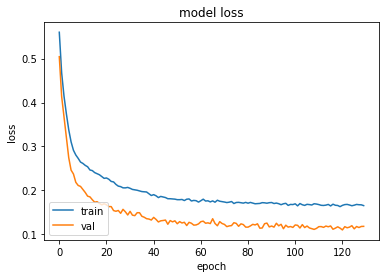

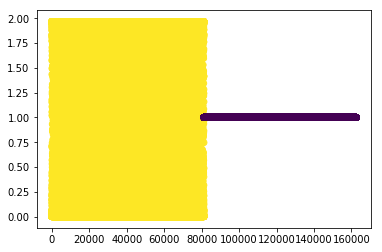

50000/50000 [==============================] - 4s 73us/step



  9%|▉         | 1/11 [04:55<49:12, 295.23s/it]

50000/50000 [==============================] - 4s 76us/step



 18%|█▊        | 2/11 [10:09<45:41, 304.61s/it]

50000/50000 [==============================] - 4s 77us/step



 27%|██▋       | 3/11 [15:30<41:21, 310.24s/it]

0.223606797749979


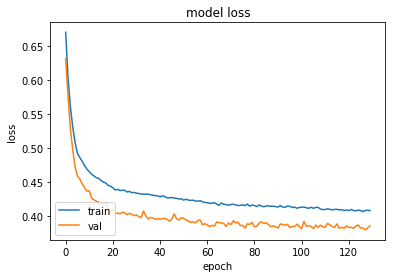

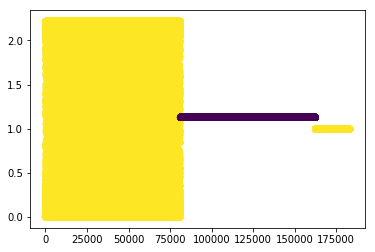

50000/50000 [==============================] - 4s 76us/step



 36%|███▋      | 4/11 [21:13<37:07, 318.25s/it]

50000/50000 [==============================] - 4s 86us/step



 45%|████▌     | 5/11 [27:04<32:28, 324.82s/it]

50000/50000 [==============================] - 4s 79us/step



 55%|█████▍    | 6/11 [33:02<27:31, 330.40s/it]

0.223606797749979


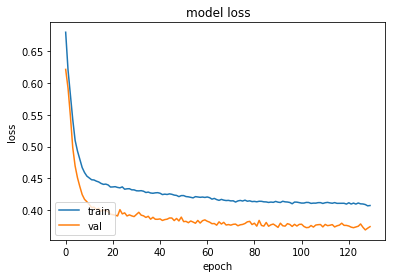

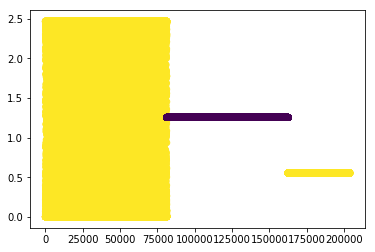

50000/50000 [==============================] - 4s 82us/step



 64%|██████▎   | 7/11 [39:29<22:34, 338.57s/it]

50000/50000 [==============================] - 6s 116us/step



 73%|███████▎  | 8/11 [46:44<17:31, 350.62s/it]

50000/50000 [==============================] - 4s 85us/step



 82%|████████▏ | 9/11 [53:37<11:54, 357.46s/it]

0.223606797749979


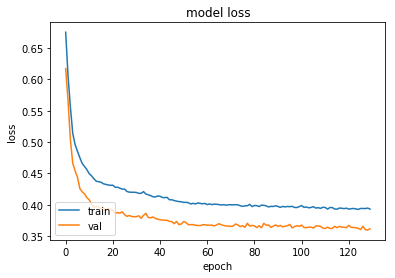

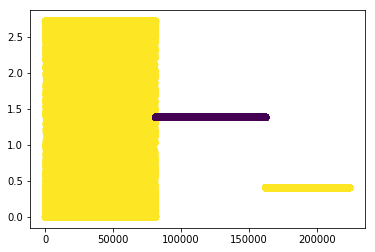

50000/50000 [==============================] - 9s 174us/step



 91%|█████████ | 10/11 [1:01:07<06:06, 366.72s/it]

50000/50000 [==============================] - 4s 86us/step



100%|██████████| 3/3 [3:16:24<00:00, 3928.02s/it]  

CPU times: user 5h 52min 42s, sys: 36min 44s, total: 6h 29min 26s
Wall time: 3h 16min 24s


In [126]:
%%time
for alpha in tqdm(alphas[3:6]):
    for i in tqdm(range(0, n_splits + 1)):
        if step*i>len(X_bad):
            end_ind=len(X_bad)
        else:   
            end_ind=step*i    
        end_ind = int(end_ind)
        cur_X = np.concatenate((X_mix, X_bad[:end_ind]))
        cur_y = np.concatenate((y_mix, np.ones((end_ind,1)))).ravel()
        cur_w = upd_weights(alpha, y_mix, w_g=gen_w_normed, num_true_bad=end_ind).ravel()
        
        idx = np.random.permutation(len(cur_y))    
    
        net = build_net()
        history = net.fit(cur_X[idx], cur_y[idx], 
                          batch_size=256, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                          sample_weight=cur_w[idx])
        if i%3==0:
            print (alpha)
            history_plot(history)
            
            plt.scatter(np.arange(len(cur_w)), cur_w, c=cur_y)#np.concatenate((y_mix, 2*np.ones((end_ind,1)))).ravel())
            plt.show()

        y_pred=net.predict_proba(X_test)
        if alpha in ours_pr_aucs:
            # append the new number to the existing array at this slot
            ours_pr_aucs[alpha].append(average_precision_score(y_test, y_pred))
            ours_roc_aucs[alpha].append(roc_auc_score(y_test, y_pred))
            ours_p_at_10[alpha].append(p_at_10(y_test, y_pred))
        else:
            # create a new array in this slot
            ours_pr_aucs[alpha] = [average_precision_score(y_test, y_pred)]
            ours_roc_aucs[alpha] = [roc_auc_score(y_test, y_pred)]
            ours_p_at_10[alpha] = [p_at_10(y_test, y_pred)]
        _eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr=alpha)

  0%|          | 0/11 [00:00<?, ?it/s]

0.30170881682725814


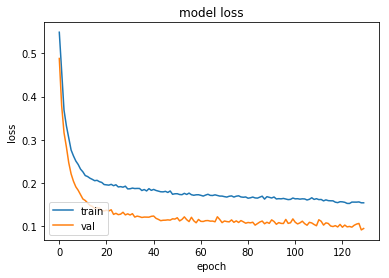

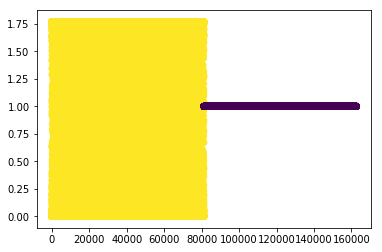

50000/50000 [==============================] - 4s 85us/step



  9%|▉         | 1/11 [05:17<52:58, 317.84s/it]

50000/50000 [==============================] - 4s 86us/step



 18%|█▊        | 2/11 [10:37<47:47, 318.66s/it]

50000/50000 [==============================] - 4s 90us/step



 27%|██▋       | 3/11 [16:31<44:04, 330.51s/it]

0.30170881682725814


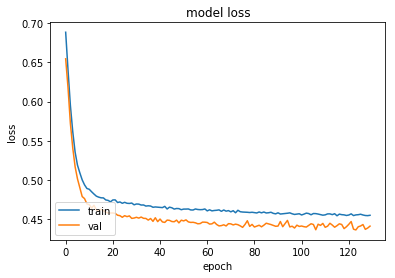

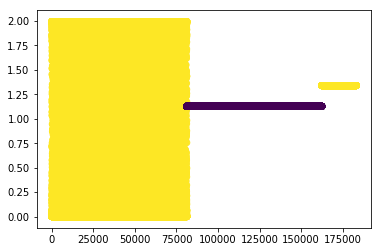

50000/50000 [==============================] - 5s 93us/step



 36%|███▋      | 4/11 [22:49<39:57, 342.50s/it]

50000/50000 [==============================] - 4s 88us/step



 45%|████▌     | 5/11 [28:49<34:35, 345.88s/it]

50000/50000 [==============================] - 7s 148us/step



 55%|█████▍    | 6/11 [35:34<29:38, 355.69s/it]

0.30170881682725814


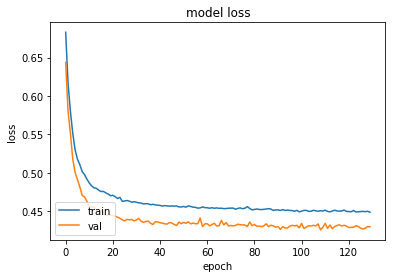

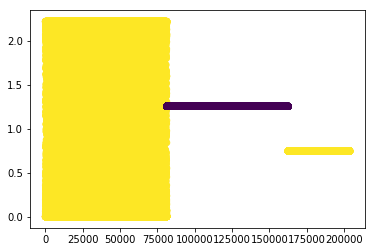

50000/50000 [==============================] - 8s 162us/step



 64%|██████▎   | 7/11 [42:53<24:30, 367.61s/it]

50000/50000 [==============================] - 7s 148us/step



 73%|███████▎  | 8/11 [50:58<19:06, 382.27s/it]

50000/50000 [==============================] - 6s 120us/step



 82%|████████▏ | 9/11 [58:13<12:56, 388.15s/it]

0.30170881682725814


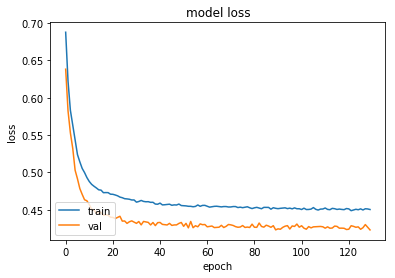

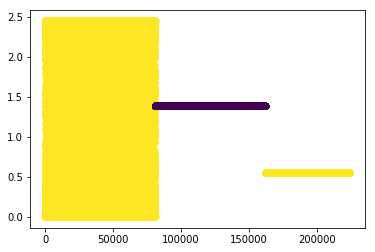

50000/50000 [==============================] - 5s 101us/step



 91%|█████████ | 10/11 [1:05:29<06:32, 392.94s/it]

50000/50000 [==============================] - 5s 109us/step



  0%|          | 0/11 [00:00<?, ?it/s]

0.4070905315369044


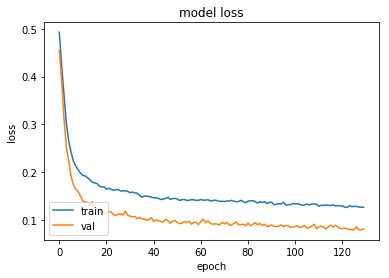

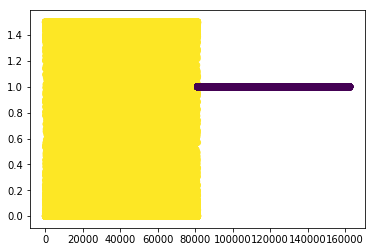

50000/50000 [==============================] - 5s 93us/step



  9%|▉         | 1/11 [05:21<53:36, 321.65s/it]

50000/50000 [==============================] - 6s 118us/step



 18%|█▊        | 2/11 [10:52<48:57, 326.40s/it]

50000/50000 [==============================] - 6s 120us/step



 27%|██▋       | 3/11 [18:08<48:21, 362.68s/it]

0.4070905315369044


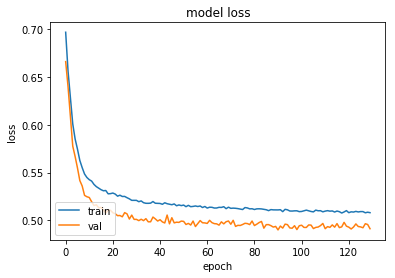

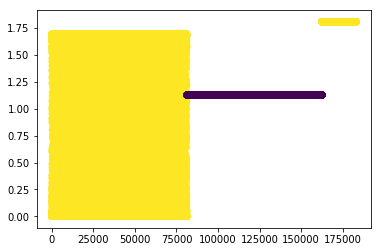

50000/50000 [==============================] - 6s 125us/step



 36%|███▋      | 4/11 [25:51<45:14, 387.75s/it]

50000/50000 [==============================] - 6s 125us/step



 45%|████▌     | 5/11 [33:45<40:30, 405.05s/it]

50000/50000 [==============================] - 6s 120us/step



 55%|█████▍    | 6/11 [41:56<34:56, 419.35s/it]

0.4070905315369044


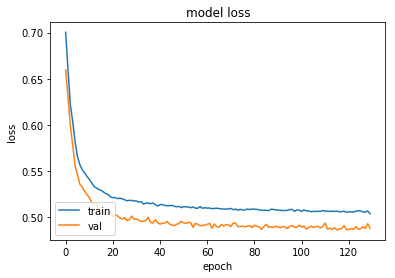

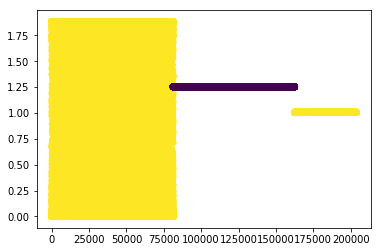

50000/50000 [==============================] - 8s 152us/step



 64%|██████▎   | 7/11 [50:34<28:53, 433.45s/it]

50000/50000 [==============================] - 6s 124us/step



 73%|███████▎  | 8/11 [59:20<22:15, 445.12s/it]

50000/50000 [==============================] - 7s 134us/step



 82%|████████▏ | 9/11 [1:08:27<15:12, 456.41s/it]

0.4070905315369044


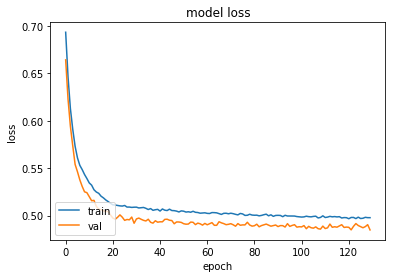

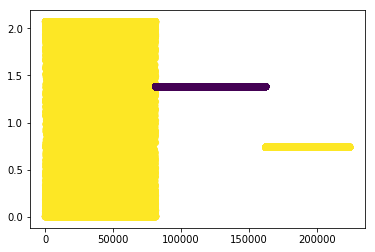

50000/50000 [==============================] - 6s 124us/step



 91%|█████████ | 10/11 [1:18:13<07:49, 469.36s/it]

50000/50000 [==============================] - 9s 182us/step



  0%|          | 0/11 [00:00<?, ?it/s]

0.5492802716530589


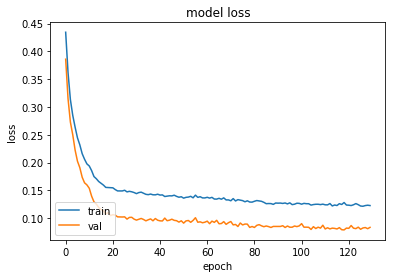

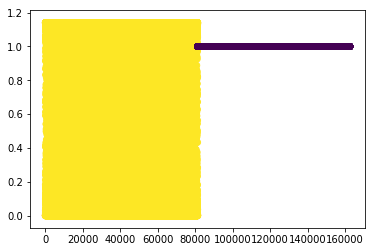

50000/50000 [==============================] - 8s 151us/step



  9%|▉         | 1/11 [07:10<1:11:44, 430.43s/it]

50000/50000 [==============================] - 7s 131us/step



 18%|█▊        | 2/11 [14:28<1:05:08, 434.27s/it]

50000/50000 [==============================] - 7s 130us/step



 27%|██▋       | 3/11 [22:03<58:50, 441.29s/it]  

0.5492802716530589


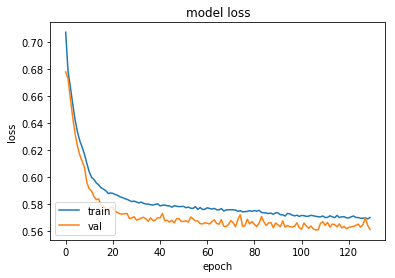

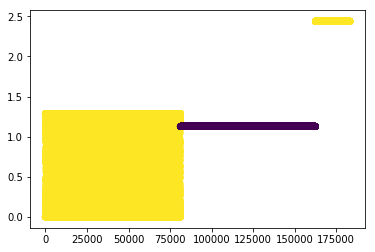

50000/50000 [==============================] - 6s 129us/step



 36%|███▋      | 4/11 [30:08<52:44, 452.04s/it]

50000/50000 [==============================] - 9s 189us/step



 45%|████▌     | 5/11 [38:27<46:09, 461.60s/it]

50000/50000 [==============================] - 7s 133us/step



 55%|█████▍    | 6/11 [46:59<39:09, 469.97s/it]

0.5492802716530589


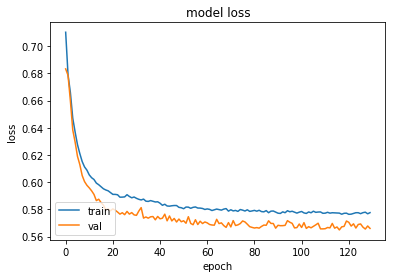

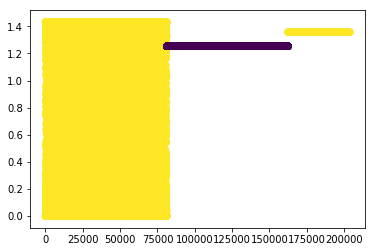

50000/50000 [==============================] - 10s 204us/step



 64%|██████▎   | 7/11 [56:08<32:04, 481.16s/it]

50000/50000 [==============================] - 7s 140us/step



 73%|███████▎  | 8/11 [1:05:22<24:30, 490.30s/it]

50000/50000 [==============================] - 8s 168us/step



 82%|████████▏ | 9/11 [1:15:03<16:40, 500.36s/it]

0.5492802716530589


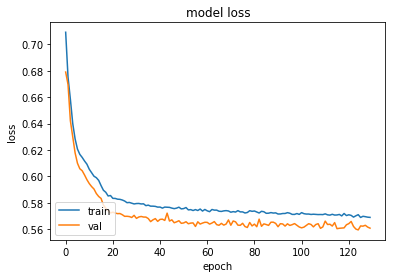

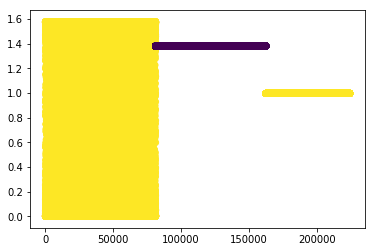

50000/50000 [==============================] - 7s 135us/step



 91%|█████████ | 10/11 [1:25:06<08:30, 510.65s/it]

50000/50000 [==============================] - 7s 145us/step



  0%|          | 0/11 [00:00<?, ?it/s]

0.7411344491069477


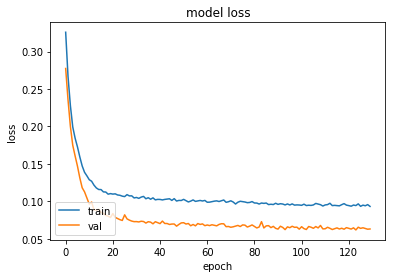

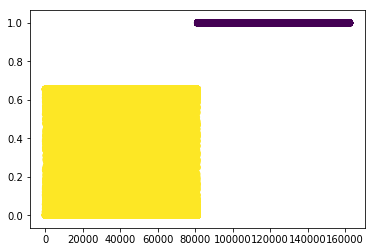

50000/50000 [==============================] - 9s 177us/step



  9%|▉         | 1/11 [07:30<1:15:06, 450.66s/it]

50000/50000 [==============================] - 7s 138us/step



 18%|█▊        | 2/11 [15:09<1:08:11, 454.60s/it]

50000/50000 [==============================] - 7s 141us/step



 27%|██▋       | 3/11 [23:09<1:01:44, 463.11s/it]

0.7411344491069477


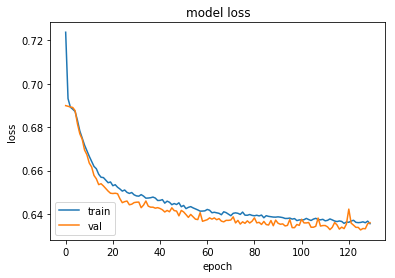

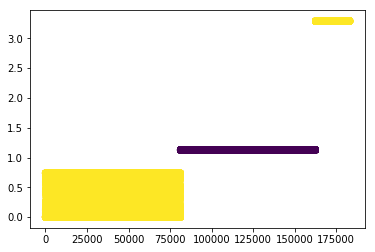

50000/50000 [==============================] - 10s 206us/step



 36%|███▋      | 4/11 [31:45<55:34, 476.40s/it]  

50000/50000 [==============================] - 11s 215us/step



 45%|████▌     | 5/11 [40:44<48:53, 488.94s/it]

50000/50000 [==============================] - 8s 150us/step



 55%|█████▍    | 6/11 [49:48<41:30, 498.13s/it]

0.7411344491069477


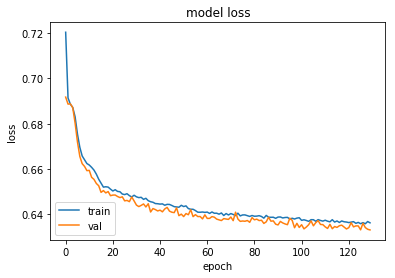

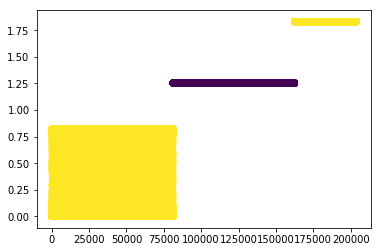

50000/50000 [==============================] - 8s 162us/step



 64%|██████▎   | 7/11 [59:26<33:57, 509.47s/it]

50000/50000 [==============================] - 8s 153us/step



 73%|███████▎  | 8/11 [1:09:13<25:57, 519.21s/it]

50000/50000 [==============================] - 7s 146us/step



 82%|████████▏ | 9/11 [1:19:20<17:37, 528.92s/it]

0.7411344491069477


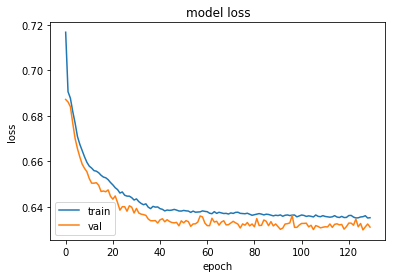

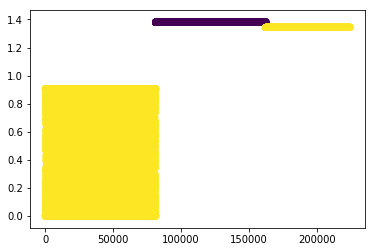

50000/50000 [==============================] - 10s 210us/step



 91%|█████████ | 10/11 [1:30:04<09:00, 540.44s/it]

50000/50000 [==============================] - 7s 149us/step



100%|██████████| 4/4 [5:57:22<00:00, 5360.74s/it]  

CPU times: user 9h 38min 57s, sys: 59min 23s, total: 10h 38min 20s
Wall time: 5h 57min 22s


In [127]:
%%time
for alpha in tqdm(alphas[6:]):
    for i in tqdm(range(0, n_splits + 1)):
        if step*i>len(X_bad):
            end_ind=len(X_bad)
        else:   
            end_ind=step*i    
        end_ind = int(end_ind)
        cur_X = np.concatenate((X_mix, X_bad[:end_ind]))
        cur_y = np.concatenate((y_mix, np.ones((end_ind,1)))).ravel()
        cur_w = upd_weights(alpha, y_mix, w_g=gen_w_normed, num_true_bad=end_ind).ravel()
        
        idx = np.random.permutation(len(cur_y))    
    
        net = build_net()
        history = net.fit(cur_X[idx], cur_y[idx], 
                          batch_size=256, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                          sample_weight=cur_w[idx])
        if i%3==0:
            print (alpha)
            history_plot(history)
            
            plt.scatter(np.arange(len(cur_w)), cur_w, c=cur_y)#np.concatenate((y_mix, 2*np.ones((end_ind,1)))).ravel())
            plt.show()

        y_pred=net.predict_proba(X_test)
        if alpha in ours_pr_aucs:
            # append the new number to the existing array at this slot
            ours_pr_aucs[alpha].append(average_precision_score(y_test, y_pred))
            ours_roc_aucs[alpha].append(roc_auc_score(y_test, y_pred))
            ours_p_at_10[alpha].append(p_at_10(y_test, y_pred))
        else:
            # create a new array in this slot
            ours_pr_aucs[alpha] = [average_precision_score(y_test, y_pred)]
            ours_roc_aucs[alpha] = [roc_auc_score(y_test, y_pred)]
            ours_p_at_10[alpha] = [p_at_10(y_test, y_pred)]
        _eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr=alpha)

In [128]:
ours_pr_aucs

{'ours with alpha=0.': array([0.45691097, 0.45691097, 0.45691097, 0.45691097, 0.45691097,
        0.45691097, 0.45691097, 0.45691097, 0.45691097, 0.45691097,
        0.45691097]),
 1: [0.5,
  0.4564743657057639,
  0.4555757181713848,
  0.455156479837069,
  0.45451950913090394,
  0.45757313820465007,
  0.45566009204642316,
  0.45607830394904014,
  0.45477386831204586,
  0.45736006753506486,
  0.45304535034309085],
 0.05000000000000001: [0.4583325035485182,
  0.4566670204979556,
  0.4567596079450319,
  0.4567539025341993,
  0.4562126766914539,
  0.4571633826287019,
  0.4567694947350565,
  0.4560925110365073,
  0.45665763945455345,
  0.4565055780582021,
  0.45752619662125604],
 0.06746414238367818: [0.4570081809464123,
  0.4569957219432433,
  0.45727449477034166,
  0.45750132152089934,
  0.4566654638091805,
  0.4564894772214493,
  0.4565935231424715,
  0.4569352773504462,
  0.4558212508769165,
  0.4571703488876982,
  0.4560203477146752],
 0.09102821015130401: [0.4558545250052817,
  0.4567

# Classic methods

## Unsupervised

In [74]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [82]:
unsupervised_pr_aucs = {}
unsupervised_roc_aucs = {}
unsupervised_p_at_10 = {}
unsupervised_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

In [83]:
def p_at_10_un(y_test, y_pred, n=10):
    try:
        ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    except:
        ind = np.argpartition(y_pred, -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean


0it [00:00, ?it/s]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/maxim/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/maxim/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/maxim/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



One-Class SVM
recall_score  0.03146715615576242
precision_score  0.46632124352331605
f1_score  0.05895598771750255
confusion_matrix 
[[26295   824]
 [22161   720]]


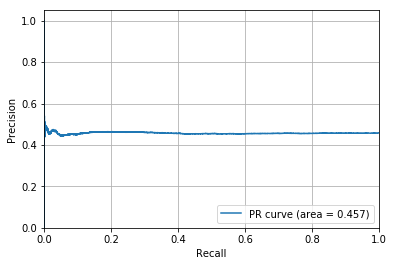

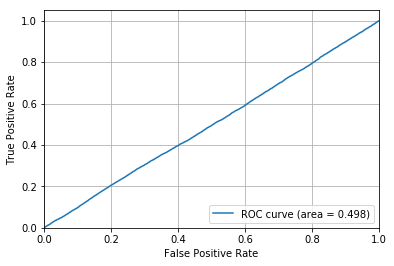

1it [01:55, 115.85s/it]

Precision at 10:  0.0
Precision at recall:  0.8 = 0.45762; 0.9 = 0.45762; 0.95 = 0.45762; 0.99 = 0.45762
Isolation Forest
recall_score  0.029675276430225953
precision_score  0.45296864576384255
f1_score  0.05570139458572601
confusion_matrix 
[[26299   820]
 [22202   679]]


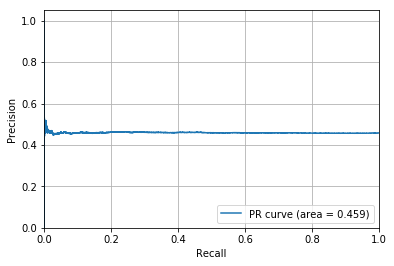

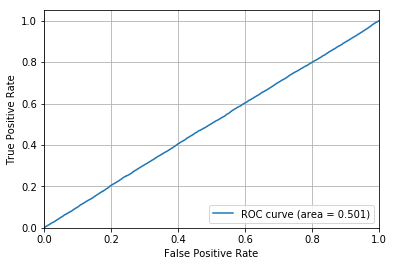

2it [02:45, 82.88s/it] 

Precision at 10:  0.0
Precision at recall:  0.8 = 0.457863465502607; 0.9 = 0.457863465502607; 0.95 = 0.457863465502607; 0.99 = 0.457863465502607


In [84]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


classifiers_classic_uns = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        max_samples=1500,
                                        contamination=0.03,
                                        random_state=10)
}


for i, (clf_name, clf) in tqdm(enumerate(classifiers_classic_uns.items())):
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
#         y_pred = clf.decision_function(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))
        

        Score = clf.decision_function(X_test)
        
        
        precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
        pr_auc = auc(recall, precision)
        unsupervised_pr_aucs[clf_name]=pr_auc      
        
        plt.figure()
        plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
        roc_auc = auc(fpr, tpr)
        unsupervised_roc_aucs[clf_name]=roc_auc
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        unsupervised_p_at_10[clf_name] = p_at_10_un(-y_test_rescale, -Score)
        _eval_p_at_rs_flatten(-y_test_rescale, -Score, unsupervised_p_at_r, descr=clf_name)
        
        print("Precision at 10: ", unsupervised_p_at_10[clf_name])
        print("Precision at recall: ", "; ".join(
            map(lambda k: "{} = {}".format(k, unsupervised_p_at_r[k][clf_name]), unsupervised_p_at_r.keys())
        ))

## Supervised

In [85]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

In [86]:
classifiers_classic_sup = {
    "XGBClassifier": xgb.XGBClassifier(n_estimators=60, max_depth=10, nthread=-1, seed=111)
}

In [87]:
supervised_pr_aucs = {}
supervised_roc_aucs = {}
supervised_p_at_10 = {}
supervised_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

In [88]:
%%time
for i, (clf_name, clf) in tqdm(enumerate(classifiers_classic_sup.items())):
    for i in range(1,n_splits+1):
        if step*i>len(X_bad):
            end_ind=len(X_bad)
        else:   
            end_ind=step*i
        end_ind = int(end_ind)
        clf.fit(np.concatenate((X_good, X_bad[:end_ind])), 
                np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel()) 
        y_pred = clf.predict_proba(X_test)[:,1]
        if clf_name in supervised_pr_aucs:
            # append the new number to the existing array at this slot
            supervised_pr_aucs[clf_name].append(average_precision_score(y_test, y_pred))
            supervised_roc_aucs[clf_name].append(roc_auc_score(y_test, y_pred))
            supervised_p_at_10[clf_name].append(p_at_10_un(y_test, y_pred))
        else:
            # create a new array in this slot
            supervised_pr_aucs[clf_name] = [average_precision_score(y_test, y_pred)]
            supervised_roc_aucs[clf_name] = [roc_auc_score(y_test, y_pred)]
            supervised_p_at_10[clf_name] = [p_at_10_un(y_test, y_pred)]
        _eval_p_at_rs(y_test, y_pred, supervised_p_at_r, descr=clf_name)

1it [05:03, 303.53s/it]

CPU times: user 4min 57s, sys: 1.88 s, total: 4min 59s
Wall time: 5min 3s


## All together

In [129]:
supervised_pr_aucs['XGBClassifier'].insert(0, 0.5), supervised_roc_aucs['XGBClassifier'].insert(0, 0.5)
supervised_pr_aucs, supervised_roc_aucs

({'XGBClassifier': [0.5,
   0.5,
   0.4561479513096368,
   0.4561803023815711,
   0.4569610657981032,
   0.4548971128995315,
   0.4557593564065303,
   0.45463240768477675,
   0.45753141435140143,
   0.4560114286692013,
   0.4538537758396073,
   0.45396366493908297]},
 {'XGBClassifier': [0.5,
   0.5,
   0.49960575564701076,
   0.49786867440791704,
   0.49784840397994073,
   0.49645667665231014,
   0.49875323653006565,
   0.49631395369381076,
   0.4996205088377334,
   0.4973738772577303,
   0.49604325855016784,
   0.4952363994666651]})

In [130]:
supervised_p_at_10['XGBClassifier'].insert(0, 0.5)
for k in supervised_p_at_r.keys():
    supervised_p_at_r[k]['XGBClassifier'].insert(0, 0.5)
supervised_p_at_10, supervised_p_at_r

({'XGBClassifier': [0.5,
   0.5,
   0.4,
   0.6,
   0.5,
   0.4,
   0.2,
   0.4,
   0.4,
   0.5,
   0.2,
   0.4]},
 {'0.8': {'XGBClassifier': [0.5,
    0.5,
    0.45799463460879036,
    0.4582043343653251,
    0.4577904092102411,
    0.4576383055322213,
    0.4576975561344746,
    0.45788728287582786,
    0.4581856400956228,
    0.45783507872223156,
    0.457774173930671,
    0.45769969585400994]},
  '0.9': {'XGBClassifier': [0.5,
    0.5,
    0.45799463460879036,
    0.45789185794453113,
    0.4576688344172086,
    0.4576383055322213,
    0.4576975561344746,
    0.45788728287582786,
    0.4581856400956228,
    0.45779754627092206,
    0.457774173930671,
    0.45769969585400994]},
  '0.95': {'XGBClassifier': [0.5,
    0.5,
    0.45799463460879036,
    0.45789185794453113,
    0.4576688344172086,
    0.4576383055322213,
    0.4576975561344746,
    0.45788728287582786,
    0.4581856400956228,
    0.4576824287338414,
    0.457774173930671,
    0.45769969585400994]},
  '0.99': {'XGBClassif

In [131]:
unsupervised_roc_aucs['Isolation Forest'] = np.ones((11))*unsupervised_roc_aucs['Isolation Forest']
unsupervised_pr_aucs['Isolation Forest'] = np.ones((11))*unsupervised_pr_aucs['Isolation Forest']
unsupervised_roc_aucs['One-Class SVM'] = np.ones((11))*unsupervised_roc_aucs['One-Class SVM']
unsupervised_pr_aucs['One-Class SVM'] = np.ones((11))*unsupervised_pr_aucs['One-Class SVM']

unsupervised_pr_aucs, unsupervised_roc_aucs 

({'Isolation Forest': array([0.45914692, 0.45914692, 0.45914692, 0.45914692, 0.45914692,
         0.45914692, 0.45914692, 0.45914692, 0.45914692, 0.45914692,
         0.45914692]),
  'One-Class SVM': array([0.45723068, 0.45723068, 0.45723068, 0.45723068, 0.45723068,
         0.45723068, 0.45723068, 0.45723068, 0.45723068, 0.45723068,
         0.45723068])},
 {'Isolation Forest': array([0.50138765, 0.50138765, 0.50138765, 0.50138765, 0.50138765,
         0.50138765, 0.50138765, 0.50138765, 0.50138765, 0.50138765,
         0.50138765]),
  'One-Class SVM': array([0.4977748, 0.4977748, 0.4977748, 0.4977748, 0.4977748, 0.4977748,
         0.4977748, 0.4977748, 0.4977748, 0.4977748, 0.4977748])})

In [132]:
unsupervised_p_at_10['Isolation Forest'] = np.ones((11))*unsupervised_p_at_10['Isolation Forest']
unsupervised_p_at_10['One-Class SVM'] = np.ones((11))*unsupervised_p_at_10['One-Class SVM']
for k in unsupervised_p_at_r.keys():
    unsupervised_p_at_r[k]['Isolation Forest'] = np.ones((11))*unsupervised_p_at_r[k]['Isolation Forest']
    unsupervised_p_at_r[k]['One-Class SVM'] = np.ones((11))*unsupervised_p_at_r[k]['One-Class SVM']

unsupervised_p_at_10 , unsupervised_p_at_r

({'Isolation Forest': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'One-Class SVM': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 {'0.8': {'Isolation Forest': array([0.45786347, 0.45786347, 0.45786347, 0.45786347, 0.45786347,
          0.45786347, 0.45786347, 0.45786347, 0.45786347, 0.45786347,
          0.45786347]),
   'One-Class SVM': array([0.45762, 0.45762, 0.45762, 0.45762, 0.45762, 0.45762, 0.45762,
          0.45762, 0.45762, 0.45762, 0.45762])},
  '0.9': {'Isolation Forest': array([0.45786347, 0.45786347, 0.45786347, 0.45786347, 0.45786347,
          0.45786347, 0.45786347, 0.45786347, 0.45786347, 0.45786347,
          0.45786347]),
   'One-Class SVM': array([0.45762, 0.45762, 0.45762, 0.45762, 0.45762, 0.45762, 0.45762,
          0.45762, 0.45762, 0.45762, 0.45762])},
  '0.95': {'Isolation Forest': array([0.45786347, 0.45786347, 0.45786347, 0.45786347, 0.45786347,
          0.45786347, 0.45786347, 0.45786347, 0.45786347, 0.45786347,
          0.45786347]),


In [133]:
ours_pr_aucs

{'ours with alpha=0.': array([0.45691097, 0.45691097, 0.45691097, 0.45691097, 0.45691097,
        0.45691097, 0.45691097, 0.45691097, 0.45691097, 0.45691097,
        0.45691097]),
 1: [0.5,
  0.4564743657057639,
  0.4555757181713848,
  0.455156479837069,
  0.45451950913090394,
  0.45757313820465007,
  0.45566009204642316,
  0.45607830394904014,
  0.45477386831204586,
  0.45736006753506486,
  0.45304535034309085],
 0.05000000000000001: [0.4583325035485182,
  0.4566670204979556,
  0.4567596079450319,
  0.4567539025341993,
  0.4562126766914539,
  0.4571633826287019,
  0.4567694947350565,
  0.4560925110365073,
  0.45665763945455345,
  0.4565055780582021,
  0.45752619662125604],
 0.06746414238367818: [0.4570081809464123,
  0.4569957219432433,
  0.45727449477034166,
  0.45750132152089934,
  0.4566654638091805,
  0.4564894772214493,
  0.4565935231424715,
  0.4569352773504462,
  0.4558212508769165,
  0.4571703488876982,
  0.4560203477146752],
 0.09102821015130401: [0.4558545250052817,
  0.4567

In [134]:
ours_pr_aucs['ours with alpha=0.'] = np.ones((11))*ours_pr_aucs['ours with alpha=0.']
ours_roc_aucs['ours with alpha=0.'] = np.ones((11))*ours_roc_aucs['ours with alpha=0.']

In [135]:
ours_p_at_10['ours with alpha=0.'] = np.ones((11))*ours_p_at_10['ours with alpha=0.']
for k in ours_p_at_r.keys():
    ours_p_at_r[k]['ours with alpha=0.'] = np.ones((11))*ours_p_at_r[k]['ours with alpha=0.']

In [136]:
ours_pr_aucs[1.0].insert(0, 0.5)
ours_roc_aucs[1.0].insert(0, 0.5)

In [137]:
ours_p_at_10[1.0].insert(0, 0.5)
for k in ours_p_at_r.keys():
    ours_p_at_r[k][1.0].insert(0, 0.5)

In [157]:
#ours_pr_aucs, ours_roc_aucs 

In [158]:
all_methods = list(unsupervised_pr_aucs.keys()) + list(ours_pr_aucs.keys()) + list(supervised_roc_aucs.keys())

In [159]:
pr_s = {k: v for d in (unsupervised_pr_aucs, ours_pr_aucs, supervised_pr_aucs) for k, v in d.items()}
roc_s = {k: v for d in (unsupervised_roc_aucs, ours_roc_aucs, supervised_roc_aucs) for k, v in d.items()}

In [160]:
p_at_10_s = {k: v for d in (unsupervised_p_at_10, ours_p_at_10, supervised_p_at_10) for k, v in d.items()}
p_at_r_s = {}
for key in ours_p_at_r.keys():
    p_at_r_s[key] = {k: v for d in (unsupervised_p_at_r[key], ours_p_at_r[key], supervised_p_at_r[key])
                     for k, v in d.items()}

In [161]:
roc_s

{'One-Class SVM': array([0.4977748, 0.4977748, 0.4977748, 0.4977748, 0.4977748, 0.4977748,
        0.4977748, 0.4977748, 0.4977748, 0.4977748, 0.4977748]),
 'Isolation Forest': array([0.50138765, 0.50138765, 0.50138765, 0.50138765, 0.50138765,
        0.50138765, 0.50138765, 0.50138765, 0.50138765, 0.50138765,
        0.50138765]),
 'ours with alpha=0.': array([0.49971063, 0.49971063, 0.49971063, 0.49971063, 0.49971063,
        0.49971063, 0.49971063, 0.49971063, 0.49971063, 0.49971063,
        0.49971063]),
 1: [0.5,
  0.4990254779827915,
  0.4976116615614212,
  0.49609984427660303,
  0.4965708077998744,
  0.5005403467905365,
  0.49959795077479824,
  0.4970713373329766,
  0.49503126089834654,
  0.4989951609776167,
  0.49324704180879236],
 0.05000000000000001: [0.4998686152984595,
  0.4961533132112027,
  0.4965423279936098,
  0.4965376544174346,
  0.49697401172070704,
  0.49737281522783405,
  0.49841999040405227,
  0.4963813329638436,
  0.4970272598691219,
  0.4975946827814925,
  0.497

In [162]:
def plot_for_comparison(dic, names, ylabel="PR AUC", y_lim=(0.3,1.0)):
    plt.figure(figsize=(9,9))
    for i, name in enumerate(names):
        plt.plot(np.arange(0, 1.1, 0.1), dic[name], label=name)
    
    plt.ylabel(ylabel)
    plt.ylim(y_lim)
    plt.xlabel("% of used anomalies")
    plt.xlim(0,1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [163]:
pr_s

{'One-Class SVM': array([0.45723068, 0.45723068, 0.45723068, 0.45723068, 0.45723068,
        0.45723068, 0.45723068, 0.45723068, 0.45723068, 0.45723068,
        0.45723068]),
 'Isolation Forest': array([0.45914692, 0.45914692, 0.45914692, 0.45914692, 0.45914692,
        0.45914692, 0.45914692, 0.45914692, 0.45914692, 0.45914692,
        0.45914692]),
 'ours with alpha=0.': array([0.45691097, 0.45691097, 0.45691097, 0.45691097, 0.45691097,
        0.45691097, 0.45691097, 0.45691097, 0.45691097, 0.45691097,
        0.45691097]),
 1: [0.5,
  0.4564743657057639,
  0.4555757181713848,
  0.455156479837069,
  0.45451950913090394,
  0.45757313820465007,
  0.45566009204642316,
  0.45607830394904014,
  0.45477386831204586,
  0.45736006753506486,
  0.45304535034309085],
 0.05000000000000001: [0.4583325035485182,
  0.4566670204979556,
  0.4567596079450319,
  0.4567539025341993,
  0.4562126766914539,
  0.4571633826287019,
  0.4567694947350565,
  0.4560925110365073,
  0.45665763945455345,
  0.456505

In [164]:
all_methods

['One-Class SVM',
 'Isolation Forest',
 'ours with alpha=0.',
 1,
 0.05000000000000001,
 0.06746414238367818,
 0.09102821015130401,
 0.12282280261157903,
 0.16572270086699933,
 0.223606797749979,
 0.30170881682725814,
 0.4070905315369044,
 0.5492802716530589,
 0.7411344491069477,
 'XGBClassifier']

In [165]:
len(all_methods)

15

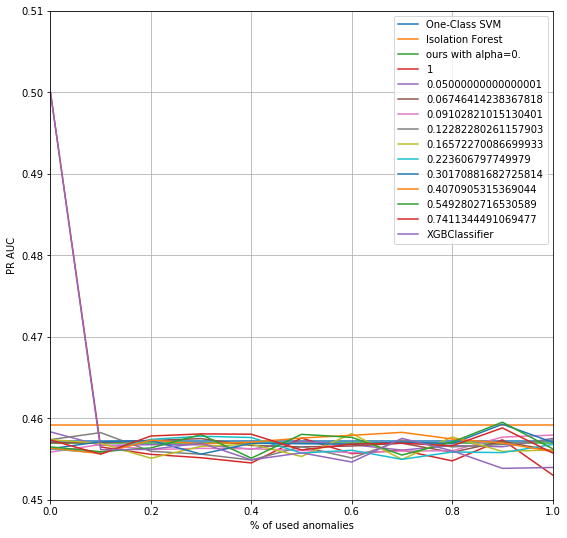

In [172]:
plot_for_comparison(pr_s, all_methods, ylabel="PR AUC",y_lim=(0.45,0.51))

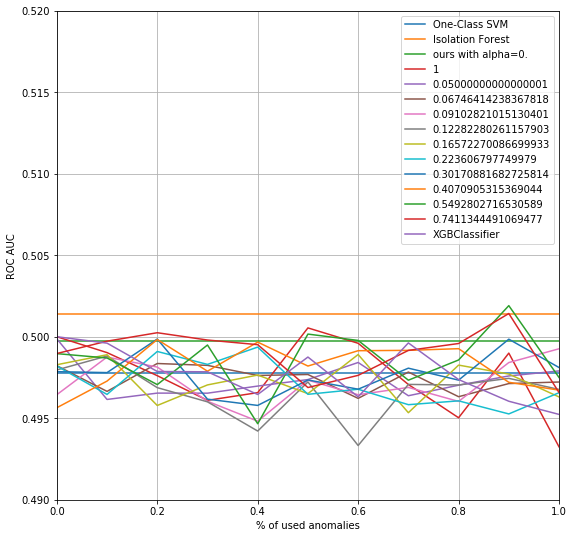

In [173]:
plot_for_comparison(roc_s, all_methods, ylabel="ROC AUC", y_lim=(0.49,0.52))

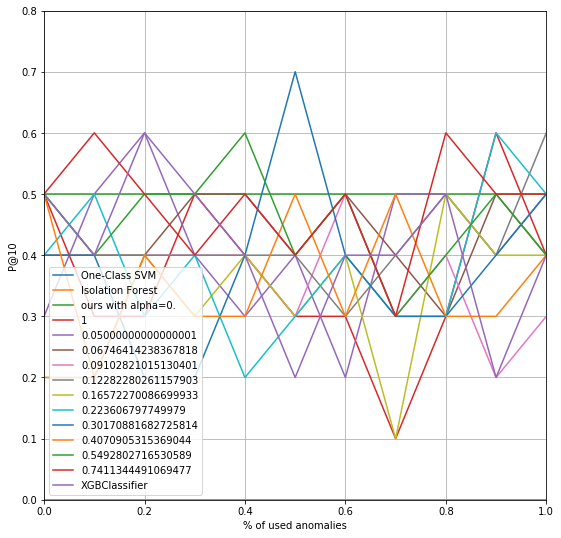

In [174]:
plot_for_comparison(p_at_10_s, all_methods, ylabel="P@10", y_lim=(0.,0.8))

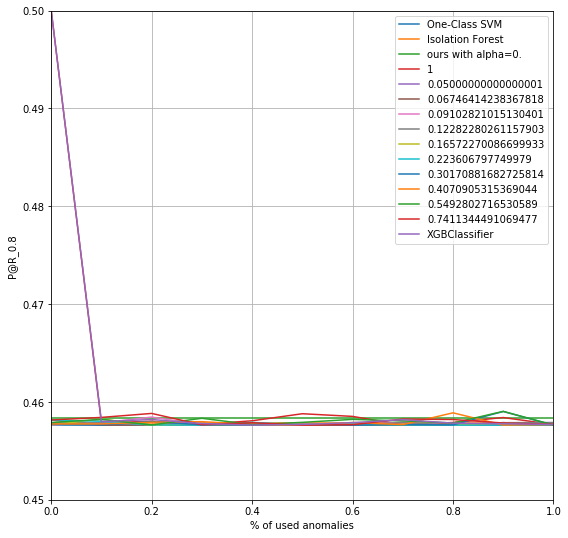

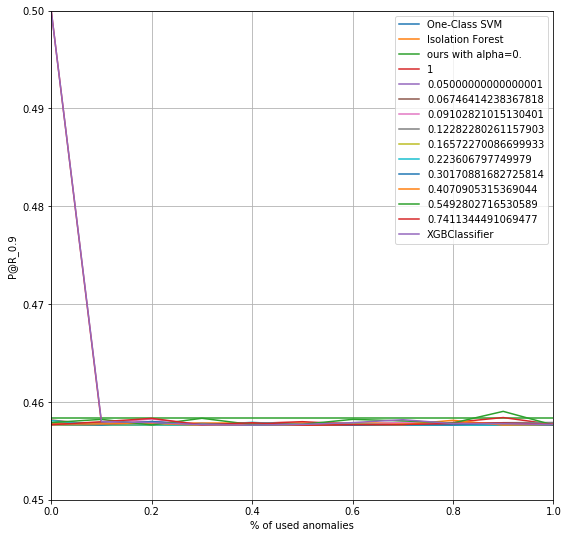

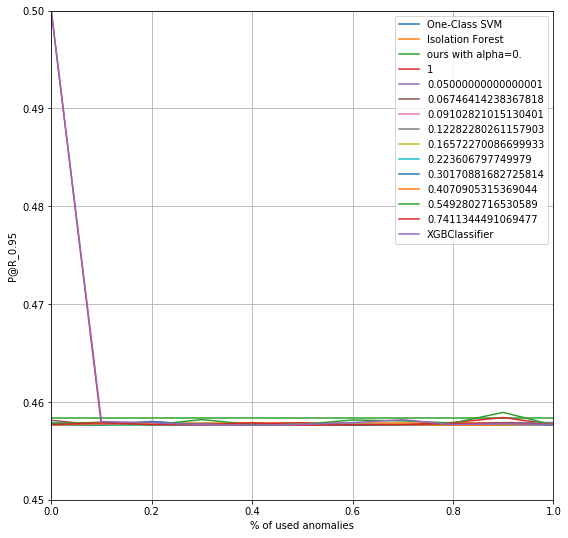

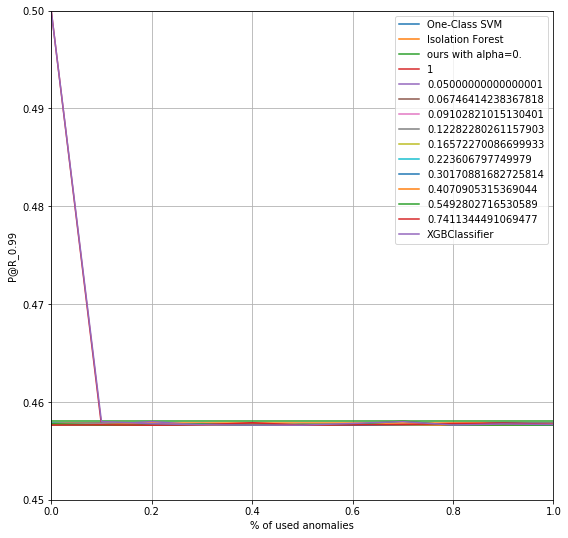

In [169]:
for key in ours_p_at_r.keys():
    plot_for_comparison(p_at_r_s[key], all_methods, ylabel="P@R_" + str(key), y_lim=(0.45,0.5))

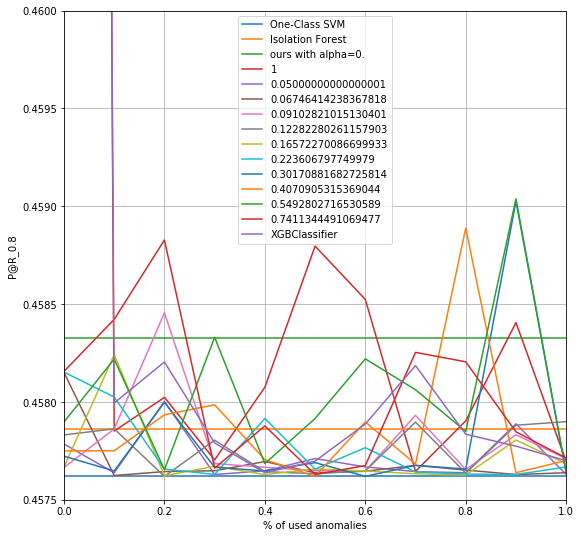

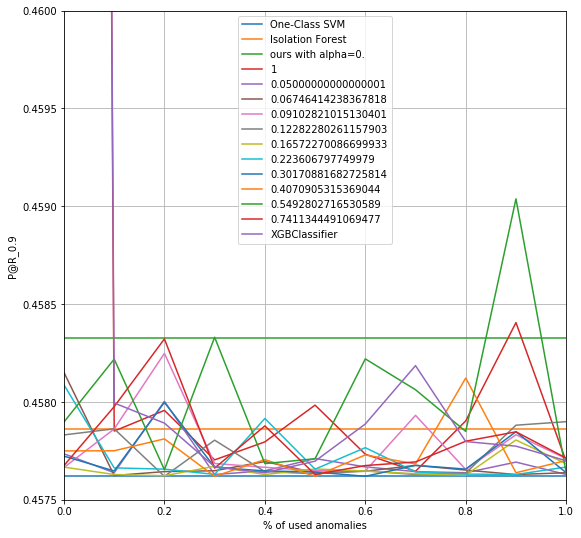

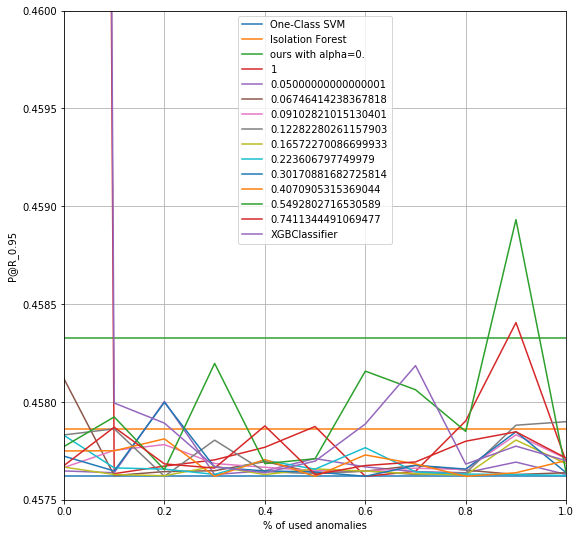

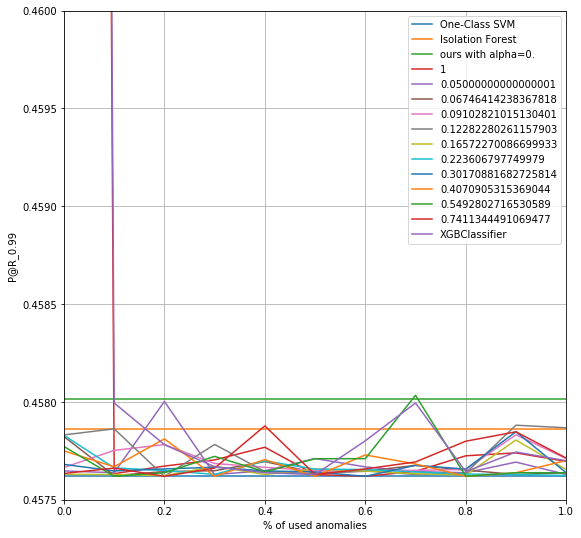

In [175]:
for key in ours_p_at_r.keys():
    plot_for_comparison(p_at_r_s[key], all_methods, ylabel="P@R_" + str(key), y_lim=(0.4575,0.46))